<a href="https://colab.research.google.com/github/krzysztofpostek/AIMMS_campus/blob/main/Network_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

installing pyomo . pyomo installed
installing and testing solvers ...
.. glpk installed
.. ipopt installed
.. gecode installed
.. bonmin installed
.. couenne installed
.. gurobi_direct installed
.. cplex_direct installed
.. cbc installed
Using the Community license in this session. If you have a full Xpress license, pass the full path to your license file to xpress.init(). If you want to use the FICO Community license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/usr/local/lib/python3.7/dist-packages/xpress/license/community-xpauth.xpr')

.. xpress installed
installation and testing complete


In [ ]:
# necessary packages and 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo

# function that uses grid_2d_graph to generate the basis undirected graph
def generate_graph(nb_nodes_x = 10, 
                   nb_nodes_y=5, 
                   total_demand=3, 
                   max_weight=10, 
                   max_uncertainty=10, 
                   max_capacity=3):

    G = nx.grid_2d_graph(nb_nodes_x, nb_nodes_y)

    # create a directed version of this graph
    Gdir = nx.DiGraph()
    # copy the nodes
    Gdir.add_nodes_from(G.nodes)
    # import the arcs and see them only as one-way arcs
    Gdir.add_edges_from(G.edges)
    # positions dictionary
    positions = {x : (10*x[0], 2 * x[1]) for x in Gdir.nodes} # positions dictionary

    # define the demands: -2 at the top left node and +2 at the top right node
    for node in Gdir.nodes:
        if node == (0, 0):
            Gdir.nodes[node]["demand"] = -total_demand
        elif node == (nb_nodes_x-1, nb_nodes_y-1):
            Gdir.nodes[node]["demand"] = total_demand
        else:
            Gdir.nodes[node]["demand"] = 0

    for edge in Gdir.edges:
        Gdir.edges[edge]["weight"] = np.ceil(np.random.rand() * max_weight)
        Gdir.edges[edge]["capacity"] = np.ceil(np.random.rand() * max_capacity)
        Gdir.edges[edge]["perturbation"] = np.ceil(np.random.rand() * max_uncertainty)
        
    return Gdir

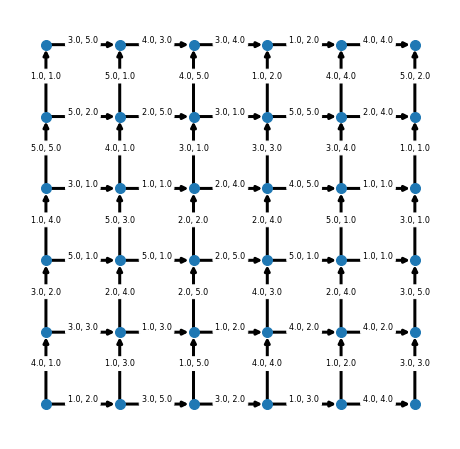

In [ ]:
i_attempt = 260
max_budget = 10
np.random.seed(i_attempt)
Gdir = generate_graph(nb_nodes_x =6, 
                   nb_nodes_y=6, 
                   total_demand=2, 
                   max_weight=5, 
                   max_uncertainty=5, 
                   max_capacity=1)

# create a dictionary with the positions of the nodes
positions = {x : (10*x[0], 2 * x[1]) for x in Gdir.nodes}

# define the optimal plot
fig, axes = plt.subplots(1, 1, figsize = (8, 8))

# first plot - the state of the network
nx.draw_networkx(Gdir, pos=positions, ax = axes, width = 3, node_size = 100, with_labels = False)
weights = nx.get_edge_attributes(Gdir,'weight')
perturbations = nx.get_edge_attributes(Gdir,'perturbation')
labels = {x: f"{weights[x]}, {perturbations[x]}" for x in weights}

nx.draw_networkx_edge_labels(Gdir, 
                             pos=positions,
                             edge_labels=labels, 
                             ax = axes,
                             font_size = 8,
                             horizontalalignment = 'center',
                             verticalalignment = 'bottom',
                             rotate = False)
axes.axis("off")
plt.savefig("this.png")

In [ ]:
# Solve the minimum cost flow using NetworkX
nominal_solution = nx.min_cost_flow(Gdir, 
                                    demand='demand', 
                                    capacity='capacity',
                                    weight='weight')

# transform the solution to a simpler form
nominal_solution = {(i, j): nominal_solution[i][j] for i in nominal_solution for j in nominal_solution[i]}